# Radar Water Observations

First step is just configuration to access radar and wofs data.

In [1]:
%%bash
cat > radar.datacube << EOF
[default]
db_hostname: agdcdev-db.nci.org.au
db_port: 6432
db_database: radar
EOF

In [17]:
import datacube
import pytz
import functools
import digitalearthau.utils
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage.filters
import matplotlib.patheffects

def localdate(ds, tz=pytz.timezone('Australia/Sydney')):
    """Extract date string, for local timezone, from dataset record"""
    return str(ds.time.begin.replace(tzinfo=pytz.timezone('UTC')).astimezone(tz))[:10]

We will build up a container for managing an observation.

In [3]:
class comparison:
    dc = {'wofs': datacube.Datacube(),
          'sar': datacube.Datacube(config='radar.datacube')}
    @classmethod
    def list_all(cls):
        """Returns list of all potential comparison instances"""
        return [cls(i) for i in cls.dc['sar'].find_datasets(product='s1_gamma0_scene')]
    def __init__(self, dataset_record):
        self.ds = dataset_record
        self.date = localdate(dataset_record)
    def __repr__(self):
        return '<' + self.date + '>'

x = comparison.list_all()
print(len(x))
x[:5]

2433


[<2016-12-15>, <2016-12-10>, <2016-12-22>, <2016-12-03>, <2017-04-03>]

Note that no grouping/fusing of radar images is occuring. TODO: This should be changed to ensure no pixels are double-counted, and will then need to switch to a grid workflow (rather than trying to fit an entire contiguous satellite pass into memory). As an initial prototype, it is simpler to just use the relatively few radar scenes as the unit of processing.

For now, just want to check for potential overlapping wofs scenes.

In [4]:
@functools.lru_cache(maxsize=None)
def f(self):
    """Search index for WOFS observations that potentially overlap the SAR observations"""
    return self.dc['wofs'].find_datasets(product="wofs_albers", geopolygon=self.ds.extent, time=self.date)
comparison.wofs_datasets = f

In [5]:
x2 = [i for i in x if i.wofs_datasets()]
len(x2)

802

It looks as though only a third of radar observations can potentially be paired with landsat observations, under the same-day constraint. Note there are more sophisticated constraints that could be considered instead, such as longer time-windows or even temporal brackets. However, same-day is fast to prototype with.

Next need to actually load the data, to determine whether datasets have overlapping valid pixels.

In [6]:
def f(self):
    """Retrieve full raster data"""
    radar = self.dc['sar'].load(product='s1_gamma0_scene', datasets=[self.ds], 
                                output_crs='epsg:3577', resolution=(25,-25))
    assert len(radar.time) == 1
    wofs = self.dc['wofs'].load(product='wofs_albers', datasets=self.wofs_datasets(), like=radar,
                                group_by='solar_day', fuse_func=digitalearthau.utils.wofs_fuser)
    assert len(wofs.time) == 1    
    
    return radar.isel(time=0), wofs.isel(time=0)
comparison.load = f

def f(self):
    """Extract and categorise comparable pixels"""
    radar, wofs = self.load()

    wet = wofs.water == 128
    dry = wofs.water == 0
    clear = wet | dry

    validradar = (radar.vv > 0) & (radar.vh > 0)

    overlap = clear & validradar
    self.overlap = overlap.data.sum()

    if self.overlap:
        def extract(subset):
            vv = radar.vv.values.ravel()[subset.values.ravel()]
            vh = radar.vh.values.ravel()[subset.values.ravel()]
            return vv, vh
        self.wet_vv, self.wet_vh = extract(wet & overlap)
        self.dry_vv, self.dry_vh = extract(dry & overlap)
    return self.overlap
comparison.overlay = f

In [8]:
%%time 
x2[0].overlay()

CPU times: user 16 s, sys: 57.6 s, total: 1min 13s
Wall time: 1min 16s


6379563

In [10]:
%%time
x3 = [i for i in x2[:10] if i.overlay()]

CPU times: user 1min 24s, sys: 2min 49s, total: 4min 13s
Wall time: 4min 30s


In [11]:
len(x3)

5

At this point all of the relevant data is available. It is useful now to aggregate before analysis.

Note, it would also have been an option to coarsely bin the measurement data at an earlier stage, to limit memory consumption.

A key point is that the relationship between polarisation bands is preserved. (This would require two-dimensional binning.)

In [14]:
wet_vv = np.concatenate([i.wet_vv for i in x3])
wet_vh = np.concatenate([i.wet_vh for i in x3])
dry_vv = np.concatenate([i.dry_vv for i in x3])
dry_vh = np.concatenate([i.dry_vh for i in x3])

Analysis will begin with visualising how the radar signal distributions depend on the wofs category.

In [13]:
sum([i.overlap for i in x3])

73740684

In [309]:
def prettyhist(vv, vh, extent=1.0, nbins=500, smoothing=0, downsampling=5, window=None, contours = [50,90,99]):
    nsamples = len(vv)
    d = downsampling # downsample factor for contour smoothing
    assert nbins//d == nbins/d # must be integer multiple
    
    counts, *edges = np.histogram2d(vh, vv, bins=nbins, range=[[0,extent]]*2) # binning
    
    nsamples -= counts[0,0] # exclude nodata
    counts[0,0] = 0
    
    downsample = counts.reshape(nbins//d,d,nbins//d,d).sum(axis=(3,1)) # aggregate to coarser bins
    flat = downsample.ravel()
    ind = np.argsort(flat)[::-1]
    cumulative = (np.cumsum(flat[ind]) * 100 / nsamples)[ind.argsort()].reshape(downsample.shape)
    smooth = scipy.ndimage.filters.gaussian_filter(cumulative, smoothing)
    
    counts[counts==0] = np.nan # mask zero counts
    plt.imshow(np.log10(counts), origin='lower', extent=[0,extent]*2)
    
    #plt.imshow(cumulative)
    c = plt.contour(smooth, levels=contours, colors='k', origin='lower', extent=[0,extent]*2)
    
    if window:
        plt.xlim(0, window)
        plt.ylim(0, window)
    
    cc = plt.clabel(c, fmt='%d%%', fontsize=12)
    plt.setp(cc, path_effects=[matplotlib.patheffects.withStroke(linewidth=3, foreground='w')])
        
    plt.xlabel('vv')
    plt.ylabel('vh')
    print(np.nansum(counts) / nsamples, cumulative.max())
#prettyhist(dry_vv, dry_vh, extent=0.6)

0.9992215393491597 99.92215393491597


Text(0.5, 1.0, 'Dry observations')

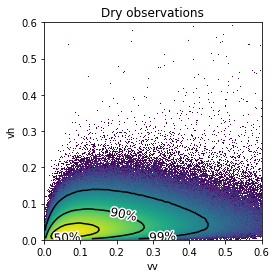

In [310]:
prettyhist(dry_vv, dry_vh, extent=0.6)
plt.title('Dry observations')

0.9975228766024659 99.75228766024658


Text(0.5, 1.0, 'Water observations')

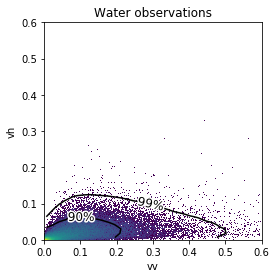

In [311]:
prettyhist(wet_vv, wet_vh, extent=0.6, downsampling=10, smoothing=1, contours=[50,90,99])
plt.title('Water observations')

0.9975228766024659 99.75228766024658


Text(0.5, 1.0, 'Water observations')

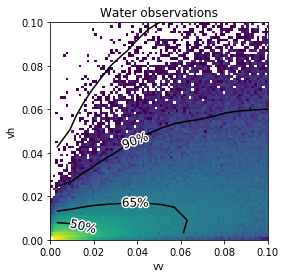

In [312]:
prettyhist(wet_vv, wet_vh, extent=0.6, window=0.1, smoothing=1, downsampling=5, contours=[50,65,90,99])
plt.title('Water observations')

0.9992215393491597 99.92215393491597


Text(0.5, 1.0, 'Dry observations')

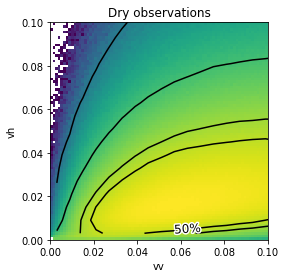

In [313]:
prettyhist(dry_vv, dry_vh, extent=0.6, window=0.1, contours=[50,65,90,99])
plt.title('Dry observations')